<a href="https://colab.research.google.com/github/VinhDevNguyen/Machine-Learning/blob/master/Project/Audio_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

In [ ]:
! mkdir genres

In [ ]:
! tar -xvzf genres.tar.gz 

# Preprocessing audio data for Deep Learning

### Import module

In [ ]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

### Waveform

In [ ]:
file = "/content/drive/My Drive/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav"

In [ ]:
signal, sr = librosa.load(file,) # sr * T -> 22050 *30
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### fft -> spectrum

In [ ]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### stft -> Spectrogram

In [ ]:
n_fft = 2048
hop_lengt = n_fft / 4

In [ ]:
stft = librosa.core.stft(signal, n_fft=n_fft, hop_length=int(hop_lengt))
stft

In [ ]:
spectrogram = abs(stft)

In [ ]:
librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_lengt)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [ ]:
log_spectrogram = librosa.core.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_lengt)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

### MFFCs

In [ ]:
MFFCs = librosa.feature.mfcc(signal)

In [ ]:
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_lengt)
plt.xlabel("Time")
plt.ylabel("MFFC")
plt.colorbar()
plt.show()

# Preparing the dataset

In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/My Drive/genres"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_mfcc=13 
n_fft=2048
hop_length=512
num_segments=5

# dictionary to store mapping, labels, and MFCCs
data = {
"mapping": [],
"labels": [],
"mfcc": []
}

samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

# loop through all genre sub-folder
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_PATH)):
  # ensure we're processing a genre sub-folder level
  if dirpath is not DATASET_PATH:
    # save genre label (i.e., sub-folder name) in the mapping
    semantic_label = dirpath.split("/")[-1]
    data["mapping"].append(semantic_label)
    print("\nProcessing: {}".format(semantic_label))

    # process all audio files in genre sub-dir
    for f in filenames:

        # load audio file
        file_path = os.path.join(dirpath, f)
        print(file_path)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        # process all segments of audio file
        for d in range(num_segments):

            # calculate start and finish sample for current segment
            start = samples_per_segment * d
            finish = start + samples_per_segment

            # extract mfcc
            mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
            mfcc = mfcc.T

            # store only mfcc feature with expected number of vectors
            if len(mfcc) == num_mfcc_vectors_per_segment:
                data["mfcc"].append(mfcc.tolist())
                data["labels"].append(i-1)
                print("segment:{}".format(d+1))

# save MFCCs to json file
with open(JSON_PATH, "w") as fp:
  json.dump(data, fp, indent=4)


# Neuron network for audio

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

## Load data

In [ ]:
with open("/content/drive/My Drive/genres/data_10.json", "r") as fp:
  data = json.load(fp)

In [ ]:
X = np.array(data["mfcc"])
y = np.array(data["labels"])

## Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Create Neural Networks

Create model

In [ ]:
model = keras.Sequential([
  # Input layer
  keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
  # Hiden layers
  keras.layers.Dense(512, activation="relu"),
  keras.layers.Dense(256, activation="relu"),
  keras.layers.Dense(64, activation="relu"),
  # Output layer
  keras.layers.Dense(10, activation="softmax")
])

Compile network

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3367)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1724416   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,872,842
Trainable params: 1,872,842
Non-trainable params: 0
_________________________________________________________________


Train network

In [ ]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          batch_size=32,
          )

Epoch 1/100
110/110 [==============================] - 1s 8ms/step - loss: 10.4183 - accuracy: 0.2876 - val_loss: 5.0336 - val_accuracy: 0.3320
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 3.7381 - accuracy: 0.3928 - val_loss: 3.9446 - val_accuracy: 0.3673
Epoch 3/100
110/110 [==============================] - 1s 6ms/step - loss: 2.5044 - accuracy: 0.4720 - val_loss: 3.5003 - val_accuracy: 0.3967
Epoch 4/100
110/110 [==============================] - 1s 7ms/step - loss: 1.8493 - accuracy: 0.5475 - val_loss: 3.1570 - val_accuracy: 0.4200
Epoch 5/100
110/110 [==============================] - 1s 6ms/step - loss: 1.4757 - accuracy: 0.6095 - val_loss: 3.0894 - val_accuracy: 0.4167
Epoch 6/100
110/110 [==============================] - 1s 6ms/step - loss: 1.1120 - accuracy: 0.6772 - val_loss: 2.9108 - val_accuracy: 0.4267
Epoch 7/100
110/110 [==============================] - 1s 6ms/step - loss: 0.9667 - accuracy: 0.7078 - val_loss: 2.9678 - val_accuracy: 0.454

## Solving Overfitting

### Plot history

Text(0.5, 1.0, 'Error eval')

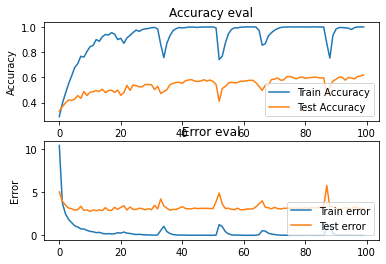

In [ ]:
import matplotlib.pyplot as plt
# Create 2 empty subplots
fig, axs = plt.subplots(2)
# Create accuracy subplot
axs[0].plot(history.history["accuracy"], label="Train Accuracy")
axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# Create error subplot
axs[1].plot(history.history["loss"], label="Train error")
axs[1].plot(history.history["val_loss"], label="Test error")
axs[1].set_ylabel("Error")
axs[1].legend(loc="lower right")
axs[1].set_title("Error eval")

### 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3367)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1724416   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

Text(0.5, 1.0, 'Error eval')

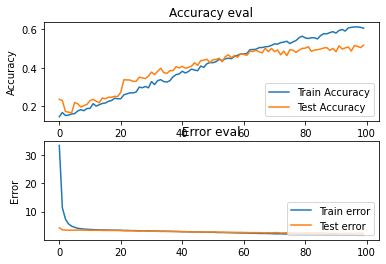

In [ ]:
model = keras.Sequential([
  # Input layer
  keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
  # Hiden layers
  keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dropout(0.3),
  # Output layer
  keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          batch_size=32,
          )
import matplotlib.pyplot as plt
# Create 2 empty subplots
fig, axs = plt.subplots(2)
# Create accuracy subplot
axs[0].plot(history.history["accuracy"], label="Train Accuracy")
axs[0].plot(history.history["val_accuracy"], label="Test Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")

# Create error subplot
axs[1].plot(history.history["loss"], label="Train error")
axs[1].plot(history.history["val_loss"], label="Test error")
axs[1].set_ylabel("Error")
axs[1].legend(loc="lower right")
axs[1].set_title("Error eval")

# CNN

## Load data

In [5]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

In [6]:
with open("/content/drive/My Drive/genres/data_10.json", "r") as fp:
  data = json.load(fp)

In [7]:
X = np.array(data["mfcc"])
y = np.array(data["labels"])

## Train test split

In [22]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [24]:
X_train.shape

(2998, 259, 13)

In [25]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [26]:
input_shape

(259, 13, 1)

In [30]:
model = keras.Sequential([
    # First conv layer
    keras.layers.Conv2D(32, (3,3), activation="relu", input_shape= input_shape),
    keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    # Second conv layer
    keras.layers.Conv2D(32, (3,3), activation="relu", input_shape= input_shape),
    keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    # Third conv layer
    keras.layers.Conv2D(32, (3,3), activation="relu", input_shape= input_shape),
    keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    # flatten output and feed it into dense layer
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    # Output layer
    keras.layers.Dense(10, activation='softmax'),
])

ValueError: ignored

Compile model

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 257, 11, 32)       320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 129, 6, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 129, 6, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 127, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 2, 32)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 2, 32)         128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 63, 1, 32)        

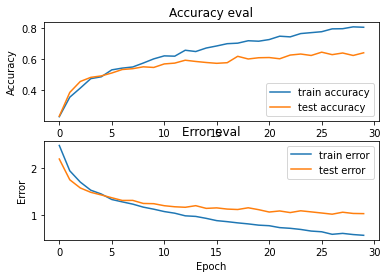

40/40 - 0s - loss: 0.9251 - accuracy: 0.6784

Test accuracy: 0.6783999800682068
Target: 4, Predicted label: [4]


In [31]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/drive/My Drive/genres/data_10.json"


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)